In [1]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from gurobipy import Model, GRB

In [3]:
from data import Dataloader
from models import RandomExampleModel, TwoClustersMIP
import metrics

In [4]:
# Loading the data
data_loader = Dataloader("../data/dataset_4") # Specify path to the dataset you want to load
X, Y = data_loader.load()


In [6]:
n_pieces = 5
n_clusters = 2
model_1 = TwoClustersMIP(n_pieces, n_clusters)
model_1.fit(X[:400,:], Y[:400,:])

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2044 rows, 1648 columns and 24816 nonzeros
Model fingerprint: 0xc9858721
Variable types: 848 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+03]
Presolve removed 10 rows and 8 columns
Presolve time: 0.05s
Presolved: 2034 rows, 1640 columns, 22380 nonzeros
Variable types: 840 continuous, 800 integer (800 binary)

Root relaxation: objective 0.000000e+00, 979 iterations, 0.03 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  228          -  

In [58]:
# Let's train an example model
model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

In [59]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.02918935  0.26452602]
 [-0.23504386 -0.06949957]
 [-0.00167842 -0.08688312]
 [-0.05042343 -0.25713769]
 [-0.04372049  0.0350513 ]]


In [7]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]]


In [7]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 0.8


In [8]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.5845
Percentage of explained preferences for all samples: 0.5845


In [9]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 0 1 0]


In [10]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [11]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 1.0
Cluster intersection for all samples: 0.6577508754377188
Cluster intersection for all samples: 0.6577508754377188


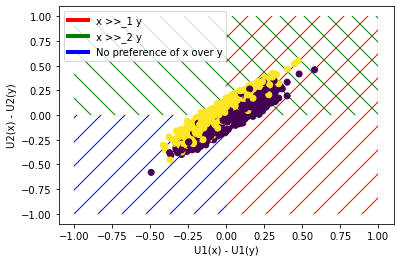

In [12]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [13]:
# This cell should work when you have completed the TwoClustersMIP model
from models import TwoClustersMIP

parameters = {"n_pieces": 5, "n_clusters": 2} # Can be completed
model = TwoClustersMIP(**parameters)
model.fit(X, Y)

# Uncomment once your model is working
# print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
# print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

In [ ]:
# As an example here are the results obtained with:
""" # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()
"""
# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

Your second assignement will be to find another model that will work well with larger data instances.

[0.         0.05050505 0.1010101  0.15151515 0.2020202  0.25252525
 0.3030303  0.35353535 0.4040404  0.45454545 0.50505051 0.55555556
 0.60606061 0.65656566 0.70707071 0.75757576 0.80808081 0.85858586
 0.90909091 0.95959596 1.01010101 1.06060606 1.11111111 1.16161616
 1.21212121 1.26262626 1.31313131 1.36363636 1.41414141 1.46464646
 1.51515152 1.56565657 1.61616162 1.66666667 1.71717172 1.76767677
 1.81818182 1.86868687 1.91919192 1.96969697 2.02020202 2.07070707
 2.12121212 2.17171717 2.22222222 2.27272727 2.32323232 2.37373737
 2.42424242 2.47474747 2.52525253 2.57575758 2.62626263 2.67676768
 2.72727273 2.77777778 2.82828283 2.87878788 2.92929293 2.97979798
 2.96969697 2.91919192 2.86868687 2.81818182 2.76767677 2.71717172
 2.66666667 2.61616162 2.56565657 2.51515152 2.46464646 2.41414141
 2.36363636 2.31313131 2.26262626 2.21212121 2.16161616 2.11111111
 2.06060606 2.01010101 1.91919192 1.81818182 1.71717172 1.61616162
 1.51515152 1.41414141 1.31313131 1.21212121 1.11111111 1.0101

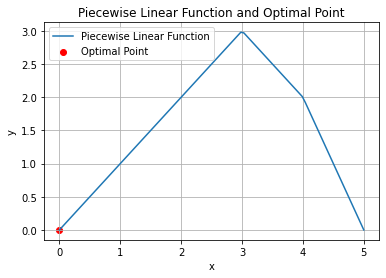

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define the piecewise linear function
breakpoints = [0, 1, 2, 3, 4, 5]
values = [0, 1, 2, 3, 2, 0]

# Create a range of x values for the plot
x_values = np.linspace(0, 5, 100)
y_values = np.interp(x_values, breakpoints, values)

# Create a Gurobi optimization model (just for reference)
model = Model()
x = model.addVar(lb=0, ub=5, name="x")
y = model.addVar(lb=0, ub=5, name="y")
model.setObjective(y, GRB.MINIMIZE)
model.optimize()

# Get the optimal value of x from the model
optimal_x = x.X

# Plot the piecewise linear function
plt.plot(x_values, y_values, label="Piecewise Linear Function")
plt.scatter([optimal_x], [np.interp(optimal_x, breakpoints, values)], color='red', label="Optimal Point")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.title("Piecewise Linear Function and Optimal Point")
plt.show()


In [12]:
from gurobipy import *

# Given points
given_points = [(1, 2), (2, 4), (3, 1), (4, 3), (5, 5)]

# Create a Gurobi optimization model
model = Model()

# Number of breakpoints (3 pieces means 4 breakpoints)
num_breakpoints = 4

# Create variables for breakpoints and values
breakpoints = []
values = []

for i in range(num_breakpoints):
    breakpoints.append(model.addVar(lb=1, ub=5, name=f"breakpoint_{i}"))

for i in range(num_breakpoints - 1):
    values.append(model.addVar(lb=0, ub=5, name=f"value_{i}"))

# Define the objective function (minimize sum of squared errors)
error_terms = []

for x, y in given_points:
    in_segment = None
    for i in range(num_breakpoints - 1):
        if x >= breakpoints[i].LB and x < breakpoints[i + 1].UB:
            in_segment = i
            break
    if in_segment is not None:
        predicted_y = values[in_segment].X + (x - breakpoints[in_segment].X) * (
                    values[in_segment + 1].X - values[in_segment].X) / (
                                  breakpoints[in_segment + 1].X - breakpoints[in_segment].X)
        error_terms.append((y - predicted_y) ** 2)

model.setObjective(quicksum(error_terms), GRB.MINIMIZE)

# Add constraints to ensure breakpoints are in ascending order
for i in range(num_breakpoints - 1):
    model.addConstr(breakpoints[i] <= breakpoints[i + 1], f"order_constraint_{i}")

# Optimize the model
model.optimize()

# Print the optimal solution
if model.status == GRB.OPTIMAL:
    print("Optimal Solution:")
    for i in range(num_breakpoints):
        print(f"breakpoint_{i} = {breakpoints[i].X}")
    for i in range(num_breakpoints - 1):
        print(f"value_{i} = {values[i].X}")
else:
    print("No solution found.")


AttributeError: Index out of range for attribute 'LB'

In [19]:
from gurobipy import Model, GRB, quicksum
import numpy as np

# Define the piecewise linear function
breakpoints = [1, 2, 3]  # breakpoints

# Dataset
x_data = np.array([0.5, 1.5, 2.5, 3.5, 4.5])  # x-values
y_data = np.array([1, 2, 3, 4, 5])  # y-values

# Create a Gurobi optimization model
model = Model()

# Add variables for the y-values at the breakpoints
y = model.addVars(breakpoints, lb=-GRB.INFINITY, name="y")

# Define the piecewise linear function
def piecewise_linear(x):
    if x < breakpoints[0]:
        return y[breakpoints[0]]
    elif x < breakpoints[1]:
        return y[breakpoints[0]] + (x - breakpoints[0]) * (y[breakpoints[1]] - y[breakpoints[0]]) / (breakpoints[1] - breakpoints[0])
    elif x < breakpoints[2]:
        return y[breakpoints[1]] + (x - breakpoints[1]) * (y[breakpoints[2]] - y[breakpoints[1]]) / (breakpoints[2] - breakpoints[1])
    else:
        return y[breakpoints[2]]

# Set the objective to minimize the sum of squared errors
model.setObjective(quicksum((y_data[i] - piecewise_linear(x_data[i]))**2 for i in range(len(x_data))), GRB.MINIMIZE)

# Optimize the model
model.optimize()

# Get the optimal y-values at the breakpoints
optimal_values = [y[i].X for i in breakpoints]

print("Optimal y-values at breakpoints:", optimal_values)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 3 columns and 0 nonzeros
Model fingerprint: 0x12ca88f7
Model has 5 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+00, 2e+01]


  QObjective range [1e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.03s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 5 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.50000000e+01  5.50000000e+01  0.00e+00 5.25e+00  0.00e+00     0s
   1   7.36842108e-01  7.36956859e-01  4.34e-10 7.21e-06  0.00e+00     0s
   2   7.36842105e-01  7.36842105e-01  7.95e-14 7.23e-12  0.00e+00     0s

Barrier solved model in 2 iterations and 0.05 seconds (0.00 work units)
Optimal objective 7.36842105e-01

Optimal y-values at breakpoints: [1.157894736841037, 2.210526315784866, 4.421052631574788]


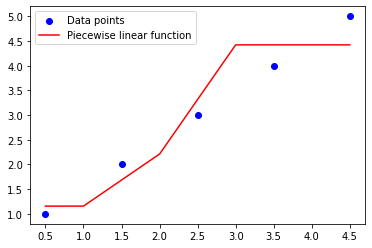

In [21]:
import matplotlib.pyplot as plt

# Plot the dataset
plt.scatter(x_data, y_data, color='blue', label='Data points')

# Generate x-values for the piecewise function
x_values = np.linspace(min(x_data), max(x_data), 1000)

# Define a function to get the y-value for a given x-value
def get_y_value(x):
    if x <= breakpoints[0]:
        return y[breakpoints[0]].X
    elif x <= breakpoints[1]:
        return y[breakpoints[0]].X + (x - breakpoints[0]) * (y[breakpoints[1]].X - y[breakpoints[0]].X) / (breakpoints[1] - breakpoints[0])
    elif x <= breakpoints[2]:
        return y[breakpoints[1]].X + (x - breakpoints[1]) * (y[breakpoints[2]].X - y[breakpoints[1]].X) / (breakpoints[2] - breakpoints[1])
    else:
        return y[breakpoints[2]].X

# Generate y-values for the piecewise function
y_values = [get_y_value(x) for x in x_values]

# Plot the piecewise function
plt.plot(x_values, y_values, color='red', label='Piecewise linear function')

plt.legend()
plt.show()

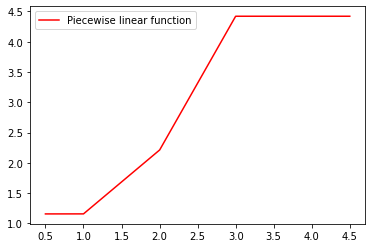

In [22]:
# Define the conditions
conditions = [x_values <= breakpoints[0], 
              (x_values > breakpoints[0]) & (x_values <= breakpoints[1]), 
              (x_values > breakpoints[1]) & (x_values <= breakpoints[2]), 
              x_values > breakpoints[2]]

# Define the functions
functions = [lambda x: y[breakpoints[0]].X, 
             lambda x: y[breakpoints[0]].X + (x - breakpoints[0]) * (y[breakpoints[1]].X - y[breakpoints[0]].X) / (breakpoints[1] - breakpoints[0]), 
             lambda x: y[breakpoints[1]].X + (x - breakpoints[1]) * (y[breakpoints[2]].X - y[breakpoints[1]].X) / (breakpoints[2] - breakpoints[1]), 
             lambda x: y[breakpoints[2]].X]

# Generate y-values for the piecewise function
y_values = np.piecewise(x_values, conditions, functions)

# Plot the piecewise function
plt.plot(x_values, y_values, color='red', label='Piecewise linear function')

plt.legend()
plt.show()

In [23]:
import gurobipy as gp
from gurobipy import GRB

def find_breakpoints(points, num_breakpoints=3):
    # Create a Gurobi model
    model = gp.Model("PiecewiseLinearFit")

    # Define the decision variables (breakpoints)
    breakpoints = []
    for i in range(num_breakpoints):
        breakpoints.append(model.addVar(vtype=GRB.CONTINUOUS, name=f"breakpoint_{i}"))

    # Set up the objective function to minimize the sum of squared errors
    objective = 0
    for x, y in points:
        piecewise_expr = 0
        for i in range(num_breakpoints):
            piecewise_expr += breakpoints[i] * (x >= breakpoints[i])
        objective += (y - piecewise_expr) ** 2
    model.setObjective(objective, GRB.MINIMIZE)

    # Add constraints to ensure breakpoints are in ascending order
    for i in range(num_breakpoints - 1):
        model.addConstr(breakpoints[i] <= breakpoints[i + 1])

    # Optimize the model
    model.optimize()

    # Extract the values of the breakpoints
    breakpoint_values = [breakpoints[i].X for i in range(num_breakpoints)]

    return breakpoint_values

# Example usage
points = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
breakpoints = find_breakpoints(points)
print("Optimal Breakpoints:", breakpoints)


TypeError: unsupported operand type(s) for *: 'Var' and 'TempConstr'

In [24]:
def find_breakpoints(points, num_breakpoints=3):
    # Create a Gurobi model
    model = gp.Model("PiecewiseLinearFit")

    # Define the decision variables (breakpoints)
    breakpoints = []
    for i in range(num_breakpoints):
        breakpoints.append(model.addVar(vtype=GRB.CONTINUOUS, name=f"breakpoint_{i}"))

    # Define the binary variables
    binary_vars = []
    for i in range(num_breakpoints):
        binary_vars.append(model.addVars(len(points), vtype=GRB.BINARY, name=f"binary_{i}"))

    # Set up the objective function to minimize the sum of squared errors
    objective = 0
    for j, (x, y) in enumerate(points):
        piecewise_expr = 0
        for i in range(num_breakpoints):
            piecewise_expr += breakpoints[i] * binary_vars[i][j]
            model.addConstr(binary_vars[i][j] >= (x - breakpoints[i]) / (max(points)[0] - min(points)[0]))
        objective += (y - piecewise_expr) ** 2
    model.setObjective(objective, GRB.MINIMIZE)

    # Add constraints to ensure breakpoints are in ascending order
    for i in range(num_breakpoints - 1):
        model.addConstr(breakpoints[i] <= breakpoints[i + 1])

    # Optimize the model
    model.optimize()

    # Extract the values of the breakpoints
    breakpoint_values = [breakpoints[i].X for i in range(num_breakpoints)]

    return breakpoint_values

# Example usage
points = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
breakpoints = find_breakpoints(points)
print("Optimal Breakpoints:", breakpoints)

TypeError: unsupported operand type(s) for ** or pow(): 'gurobipy.QuadExpr' and 'int'